In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df_rewards = pd.read_csv('./out/cumulated_reward.csv', index_col=[0, 1])
df_rewards

reward     reward.1     reward.2     reward.3  \
               createdAt                                                        
MABTree Random 2024-10-02    53.778005    48.341667    53.633050    48.294444   
               2024-10-03    86.518481    80.103889    87.246383    74.434167   
               2024-10-04   123.637092   112.983145   123.367574   117.639802   
               2024-10-05   145.894522   137.255575   157.740629   143.122381   
               2024-10-06   170.116467   166.720099   186.569320   176.272103   
...                                ...          ...          ...          ...   
LinUCB         2024-12-18  3393.359197  3393.359197  3393.359197  3393.359197   
               2024-12-19  3438.827609  3438.827609  3438.827609  3438.827609   
               2024-12-20  3478.117054  3478.117054  3478.117054  3478.117054   
               2024-12-21  3511.423602  3511.423602  3511.423602  3511.423602   
               2024-12-22  3552.908403  3552.908403  3552.908403  3552.908403   

                              reward.4     reward.5     reward.6     reward.7  \
               createdAt                                                        
MABTree Random 2024-10-02    42.385266    39.028492    39.214784    48.709943   
               2024-10-03    70.920624    70.461259    75.652284    82.044269   
               2024-10-04   102.880465   101.952647   107.767438   113.935340   
               2024-10-05   129.414909   132.375028   137.958073   141.477523   
               2024-10-06   157.512409   164.882806   160.209184   173.761967   
...                                ...          ...          ...          ...   
LinUCB         2024-12-18  3393.359197  3393.359197  3393.359197  3393.359197   
               2024-12-19  3438.827609  3438.827609  3438.827609  3438.827609   
               2024-12-20  3478.117054  3478.117054  3478.117054  3478.117054   
               2024-12-21  3511.423602  3511.423602  3511.423602  3511.423602   
               2024-12-22  3552.908403  3552.908403  3552.908403  3552.908403   

                              reward.8     reward.9  
               createdAt                             
MABTree Random 2024-10-02    39.856944    51.358651  
               2024-10-03    72.448889    85.642540  
               2024-10-04   107.965556   121.220317  
               2024-10-05   134.106825   151.168571  
               2024-10-06   167.667257   180.979127  
...                                ...          ...  
LinUCB         2024-12-18  3393.359197  3393.359197  
               2024-12-19  3438.827609  3438.827609  
               2024-12-20  3478.117054  3478.117054  
               2024-12-21  3511.423602  3511.423602  
               2024-12-22  3552.908403  3552.908403  

[574 rows x 10 columns]

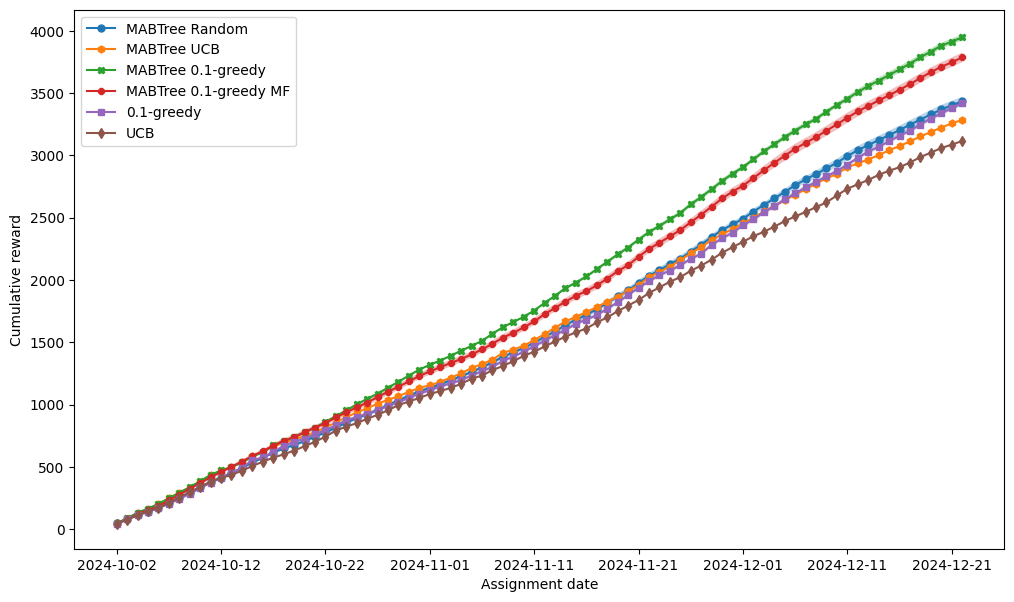

In [2]:
plt.figure(figsize=(12, 7))
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
for marker, (name, group) in zip(['o', 'h', 'X', '8', 's', 'd'], df_rewards.groupby(level=0, sort=False)):
    m = group.mean(axis=1)
    s = group.std(axis=1)

    CI_min = m - 1.96 * s / group.shape[1] ** 0.5
    CI_max = m + 1.96 * s / group.shape[1] ** 0.5

    plt.plot(group.index.get_level_values(1), m, label=name, marker=marker, markersize=5)
    plt.fill_between(group.index.get_level_values(1), CI_min, CI_max, alpha=0.3)

plt.ylabel('Cumulative reward')
plt.xlabel('Assignment date')
plt.legend()
plt.savefig('./out/cumulative_reward.pdf', format='pdf', bbox_inches='tight')
plt.show()

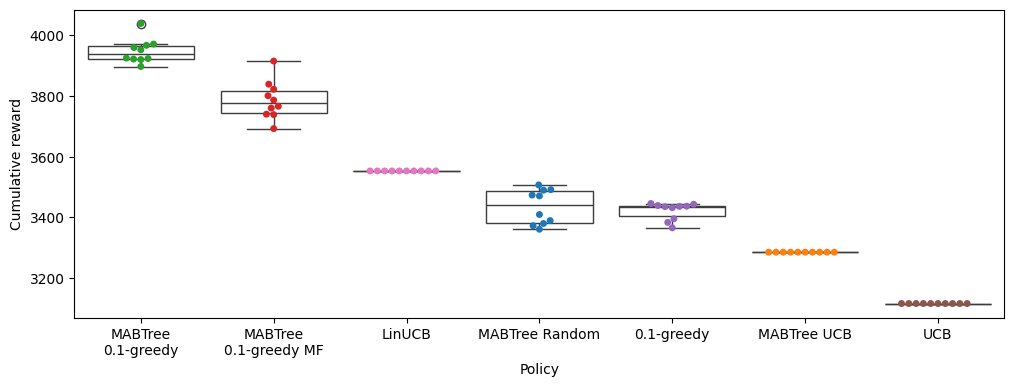

In [3]:
import seaborn as sns
final_cumulative_reward = df_rewards.groupby(level=0, sort=False).last().T
renamed = final_cumulative_reward.rename(columns={
    'MABTree 0.1-greedy': 'MABTree\n0.1-greedy',
    'MABTree 0.1-greedy MF': 'MABTree\n0.1-greedy MF'
})
rank = renamed.median().sort_values(ascending=False).index

plt.figure(figsize=(12, 4))
sns.boxplot(data=renamed, color='white', order=rank)
sns.swarmplot(data=renamed)
plt.ylabel('Cumulative reward')
plt.xlabel('Policy')
plt.savefig('./out/cumulative_reward_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [4]:
def highlight_max(s):
    d = s.sort_values(ascending=False)

    style = {
        d.index[0]: 'textbf:--rwrap ;',   # max
        d.index[1]: 'underline:--rwrap ;',  # second max
        d.index[-1]: 'textit:--rwrap ;',  # min
    }

    return [style.get(v, '') for v in s.index]

final_cumulative_reward = final_cumulative_reward.reset_index(drop=True)

final_cumulative_reward \
    .describe().loc[['mean', 'std', 'min', 'max', '50%']].T \
    .style.format('{:.3f}', escape=True).apply(highlight_max, axis=0) \
    .to_latex('./out/cumulative_reward_stats.tex', position='t', position_float='centering', hrules=True, caption='Cumulative reward statistics. The best and second best values of each column are highlighted in bold and underlined, respectively. The worst value is italicized.', label='tab:cumulative_reward_stats')

In [5]:
from scipy import stats


tukey_hsd = pd.DataFrame(
    columns=renamed.columns,
    index=renamed.columns,
    data=stats.tukey_hsd(*[renamed[col] for col in renamed.columns]).pvalue
)

tukey_hsd.map(lambda x: '< 0.01' if x < 0.01 else '< 0.05' if x < 0.05 else 'non stat-sig') \
    .style.to_latex('./out/tukey_hsd.tex', position='t', position_float='centering', hrules=True, caption='Tukey HSD test results. The p-values are reported.', label='tab:tukey_hsd')

# Coverage

In [6]:
df_coverage = pd.read_csv('./out/coverage.csv', index_col=[0])
df_coverage

,MABTree Random,MABTree UCB,MABTree 0.1-greedy,MABTree 0.1-greedy MF,0.1-greedy,UCB,LinUCB
0,0.808026,0.392817,0.334844,0.715736,0.329996,0.443045,0.486934
1,0.807991,0.392817,0.340165,0.715490,0.330945,0.443045,0.486934
2,0.810520,0.392817,0.338286,0.724658,0.332086,0.443045,0.486934
3,0.809343,0.392817,0.333948,0.722111,0.332332,0.443045,0.486934
4,0.808535,0.392817,0.335968,0.731419,0.331805,0.443045,0.486934
5,0.807938,0.392817,0.335599,0.723288,0.330576,0.443045,0.486934
6,0.808904,0.392817,0.338426,0.715560,0.330330,0.443045,0.486934
7,0.807745,0.392817,0.334334,0.732596,0.332086,0.443045,0.486934
8,0.809765,0.392817,0.335458,0.715841,0.329680,0.443045,0.486934
9,0.807113,0.392817,0.336372,0.724816,0.332104,0.443045,0.486934


In [7]:
final_cumulative_reward

,MABTree Random,MABTree UCB,MABTree 0.1-greedy,MABTree 0.1-greedy MF,0.1-greedy,UCB,LinUCB
0,3360.589333,3284.783678,3952.834353,3766.446571,3431.492092,3115.335922,3552.908403
1,3470.527937,3284.783678,3967.478050,3915.561505,3383.140938,3115.335922,3552.908403
2,3409.129676,3284.783678,3922.167241,3740.168435,3436.600620,3115.335922,3552.908403
3,3506.683166,3284.783678,4039.446369,3839.239798,3443.125027,3115.335922,3552.908403
4,3388.960917,3284.783678,3960.111023,3822.349523,3365.141576,3115.335922,3552.908403
5,3379.516446,3284.783678,3897.588020,3760.416864,3438.866444,3115.335922,3552.908403
6,3372.107484,3284.783678,3920.679167,3801.136599,3445.404146,3115.335922,3552.908403
7,3491.112820,3284.783678,3925.434119,3738.826895,3395.168078,3115.335922,3552.908403
8,3489.413016,3284.783678,3923.885510,3786.784607,3435.950897,3115.335922,3552.908403
9,3473.244220,3284.783678,3971.619569,3692.598647,3434.987025,3115.335922,3552.908403


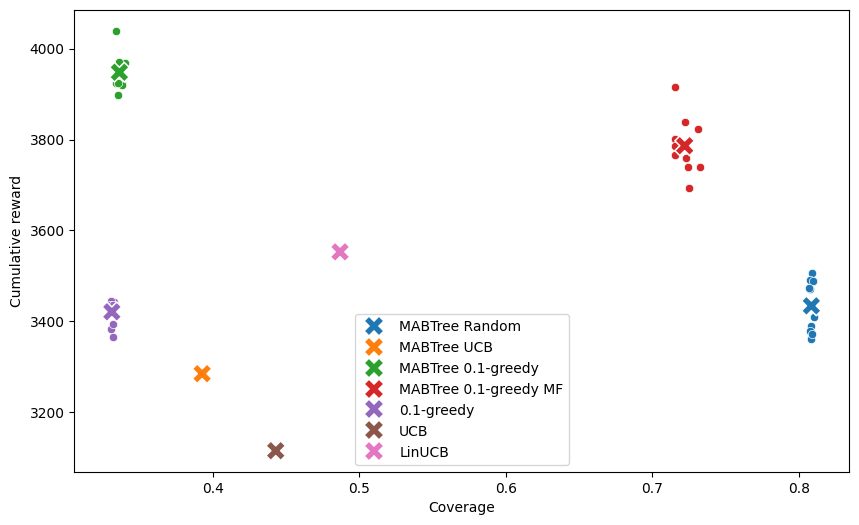

In [8]:
ax = plt.figure(figsize=(10, 6)).gca()
for x, y in zip(df_coverage, final_cumulative_reward):
    sns.scatterplot(x=df_coverage[x], y=final_cumulative_reward[y], ax=ax)
sns.scatterplot(x=df_coverage.mean(axis=0), y=final_cumulative_reward.mean(axis=0), hue=df_coverage.columns, s=200, marker='X', ax=ax)

plt.xlabel('Coverage')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('./out/cumulative_reward_vs_coverage.pdf', format='pdf')
plt.show()

# Intra user diversity

In [9]:
df_diversity = pd.read_csv('./out/diversity.csv', index_col=[0])
df_diversity

,MABTree Random,MABTree UCB,MABTree 0.1-greedy,MABTree 0.1-greedy MF,0.1-greedy,UCB,LinUCB
0,-4.435738,-4.8895,-5.779542,-4.781299,-5.842472,-4.81595,-4.887007
1,-4.436796,-4.8895,-5.775867,-4.755433,-5.852207,-4.81595,-4.887007
2,-4.434984,-4.8895,-5.778374,-4.727076,-5.835538,-4.81595,-4.887007
3,-4.436349,-4.8895,-5.775164,-4.726837,-5.837957,-4.81595,-4.887007
4,-4.437920,-4.8895,-5.774626,-4.738293,-5.849713,-4.81595,-4.887007
5,-4.435694,-4.8895,-5.779441,-4.758886,-5.834492,-4.81595,-4.887007
6,-4.435727,-4.8895,-5.790034,-4.759100,-5.863787,-4.81595,-4.887007
7,-4.435973,-4.8895,-5.783080,-4.740212,-5.853574,-4.81595,-4.887007
8,-4.435678,-4.8895,-5.781448,-4.762594,-5.825851,-4.81595,-4.887007
9,-4.437066,-4.8895,-5.768613,-4.766699,-5.860444,-4.81595,-4.887007


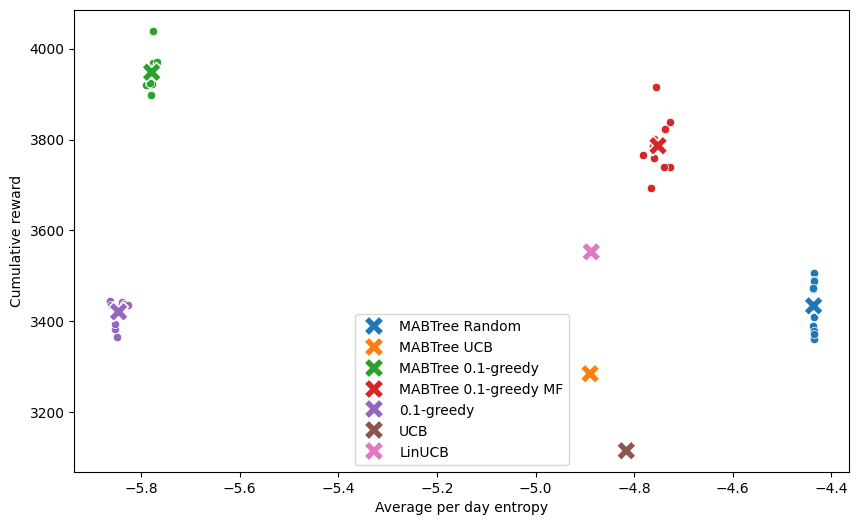

In [10]:
ax = plt.figure(figsize=(10, 6)).gca()
for x, y in zip(df_diversity, final_cumulative_reward):
    sns.scatterplot(x=df_diversity[x], y=final_cumulative_reward[y], ax=ax)
sns.scatterplot(x=df_diversity.mean(axis=0), y=final_cumulative_reward.mean(axis=0), hue=df_diversity.columns, s=200, marker='X', ax=ax)

plt.xlabel('Average per day entropy')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('./out/cumulative_reward_vs_entropy.pdf', format='pdf')
plt.show()